In [1]:
!pip install xgboost
!pip install sklearn

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%reload_ext autoreload
%autoreload 1
%aimport utils

# og_data = pd.read_csv('data.csv')
og_data = pd.read_csv('data_engineered.csv', parse_dates=['game_date'])

In [3]:
utils.engineer_features_and_write_file(pd.read_csv('data.csv'))

In [4]:
#feature engineering
#data parsing
og_data.seconds_remaining = pd.to_timedelta(og_data.seconds_remaining, unit='s')
og_data.minutes_remaining = pd.to_timedelta(og_data.minutes_remaining, unit='m')
og_data['time_remaining'] = og_data.minutes_remaining+og_data.seconds_remaining

#binning of time_remaining
time_remaining_bins_labels = [[
    pd.Timedelta(minutes = 0),
    pd.Timedelta(minutes = 5),
    pd.Timedelta(minutes = 10),
    pd.Timedelta(minutes = 20)
], ['0-5min', '5-10min', '10-20min']]

og_data['time_remaining_label'] = pd.cut(og_data['time_remaining'], time_remaining_bins_labels[0], labels = time_remaining_bins_labels[1])
og_data['time_remaining_label2']=og_data['time_remaining_label'].astype('category').cat.codes

og_data["game_date"] = pd.to_datetime(og_data["game_date"])
og_data = og_data.sort_values(by="game_date")
# Handle dates
og_data["game_year"] = og_data["game_date"].dt.year
og_data["game_month"] = og_data["game_date"].dt.month
og_data["game_day"] = og_data["game_date"].dt.day

#use only if data needs to be regenerated
# utils.engineer_features_and_write_file(og_data)

#there are 5000 shot_made_flag null values, that's our test data, the rest is training data
test = og_data.loc[og_data['shot_made_flag'].isnull()]
data = og_data.loc[og_data['shot_made_flag'].notnull()]

feature_switch = {
    'distance_traveled': 1,
    'right_of_net': 1,
    'shot_distance': 1,
    'period': 1,
    'home_game': 1,
    'shot_zone_area2': 1,
    'playoffs': 1,
    'time_remaining_label2': 1,
    'efficiency_normalized': 1,
    'action_type2': 1,
    'combined_shot_type2': 1,
    'opponent2': 1,
    'game_year': 1,
    'game_month': 1,
    'game_day': 1,
    'angle': 1
}

chosen_features = [key for key, value in feature_switch.items() if value == 1]

og_data.describe()


,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,...,shot_zone_area2,angle,distance,distance_traveled,right_of_net,time_remaining,time_remaining_label2,game_year,game_month,game_day
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697,30697.000000,30697.000000,30697,...,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697,30697.000000,30697.000000,30697.000000,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,0 days 00:04:53.137440140,2.519432,0.146562,0 days 00:00:28.365084535,...,2.438023,3.348259,138.476605,13.608701,0.554321,0 days 00:05:21.502524676,0.617161,2006.098446,5.578460,15.352477
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,0 days 00:03:26.993848667,1.153665,0.353674,0 days 00:00:17.478949230,...,1.532001,47.654774,94.919782,7.569623,0.497049,0 days 00:03:28.175175675,0.726174,4.835462,4.155881,8.797082
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0 days 00:00:00,1.000000,0.000000,0 days 00:00:00,...,0.000000,-90.000000,0.000000,0.115542,0.000000,0 days 00:00:00,-1.000000,1996.000000,1.000000,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,0 days 00:02:00,1.000000,0.000000,0 days 00:00:13,...,1.000000,-35.217593,53.338541,6.859679,0.000000,0 days 00:02:22,0.000000,2002.000000,2.000000,8.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,0 days 00:05:00,3.000000,0.000000,0 days 00:00:28,...,2.000000,0.000000,154.350251,12.322105,1.000000,0 days 00:05:04,1.000000,2006.000000,4.000000,15.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,0 days 00:08:00,3.000000,0.000000,0 days 00:00:43,...,4.000000,44.510304,211.243935,19.347203,1.000000,0 days 00:08:18,1.000000,2010.000000,11.000000,23.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,0 days 00:11:00,7.000000,1.000000,0 days 00:00:59,...,5.000000,90.000000,791.818792,83.042138,1.000000,0 days 00:11:54,2.000000,2016.000000,12.000000,31.000000


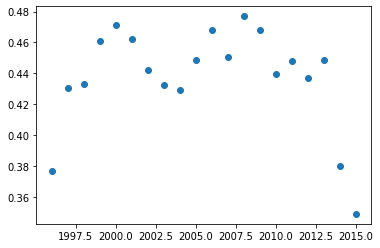

In [5]:
#plot out accuracy per year

year = data.apply(lambda row: row['game_date'].year, axis=1)

accuracy_per_year = []

for i in range(1996, 2016):
    numAttempted = len(data[(year == i)])
    numScored = len(data[(year == i) & (data['shot_made_flag'] == 1)])
    accuracy_per_year.append(numScored / numAttempted)

plt.scatter(range(1996,2016), accuracy_per_year)

(25697, 16)
(25697, 9)


<AxesSubplot:>

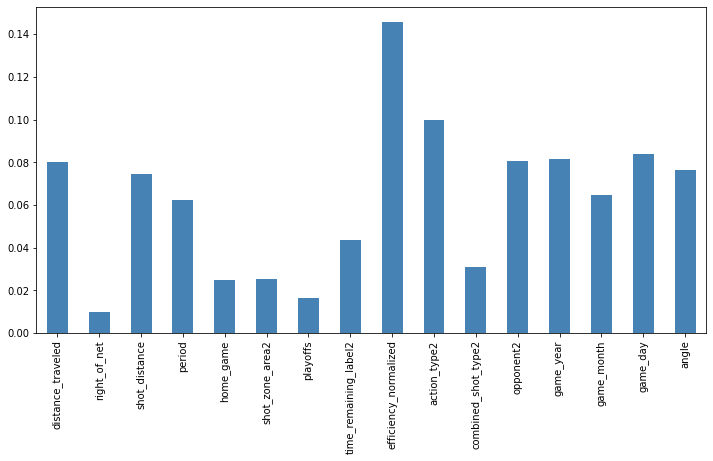

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

print(X.shape)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6))

(25697, 16)
(25697, 5)


<AxesSubplot:>

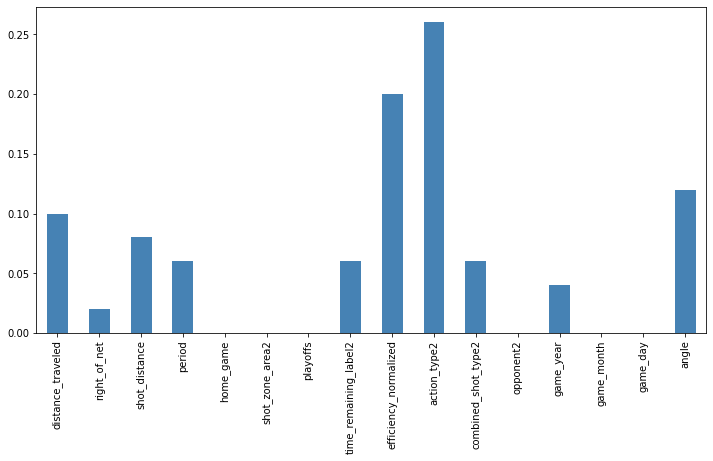

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

print(X.shape)

clf = AdaBoostClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6))

(25697, 16)


<AxesSubplot:>

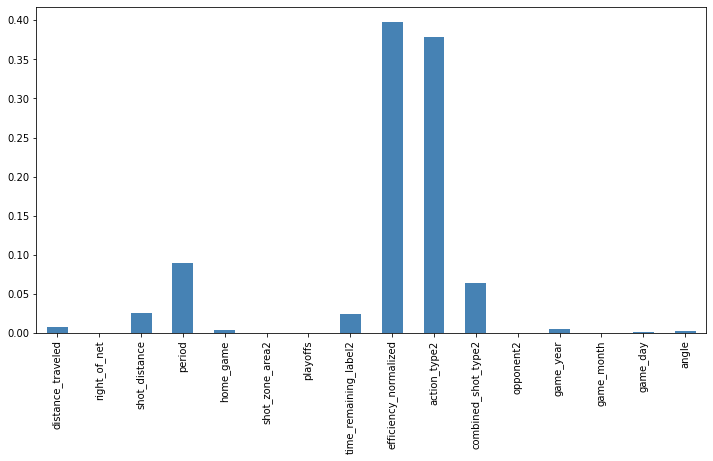

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

print(X.shape)

clf = GradientBoostingClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6))

(25697, 16)


<AxesSubplot:>

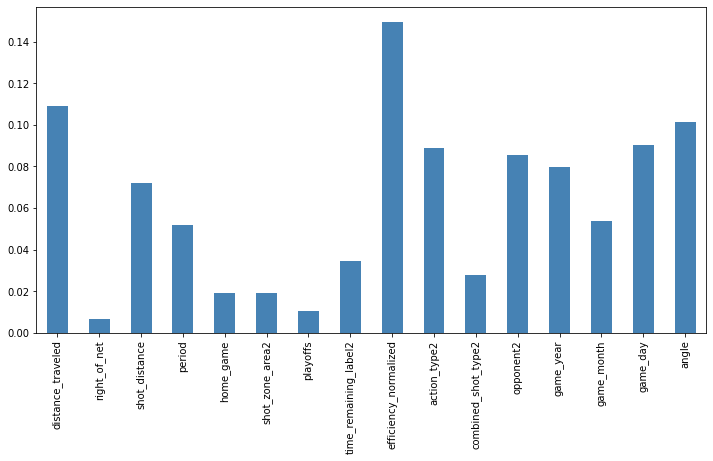

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

print(X.shape)

clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6))

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

target = data['shot_made_flag']
trainData = data[chosen_features]

print("Five-fold cross validation on Gradient Boosting: ")
X = trainData
y = target
gradient = GradientBoostingClassifier(n_estimators=100, max_depth=4)

score = cross_val_score(gradient, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on Gradient Boosting: 
0.6337725170228732


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

target = data['shot_made_flag']
trainData = data[chosen_features]

print("Five-fold cross validation on Random Forest: ")
X = trainData
y = target
rf = RandomForestClassifier(n_estimators=200, max_depth=8)

score = cross_val_score(rf, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on Random Forest: 
0.6729962452384035


In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

target = data['shot_made_flag']
trainData = data[chosen_features]

print("Five-fold cross validation on AdaBoost: ")
X = trainData
y = target
adaBoost = AdaBoostClassifier(n_estimators=100, random_state=0)

score = cross_val_score(adaBoost, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on AdaBoost: 
0.6323710043665477


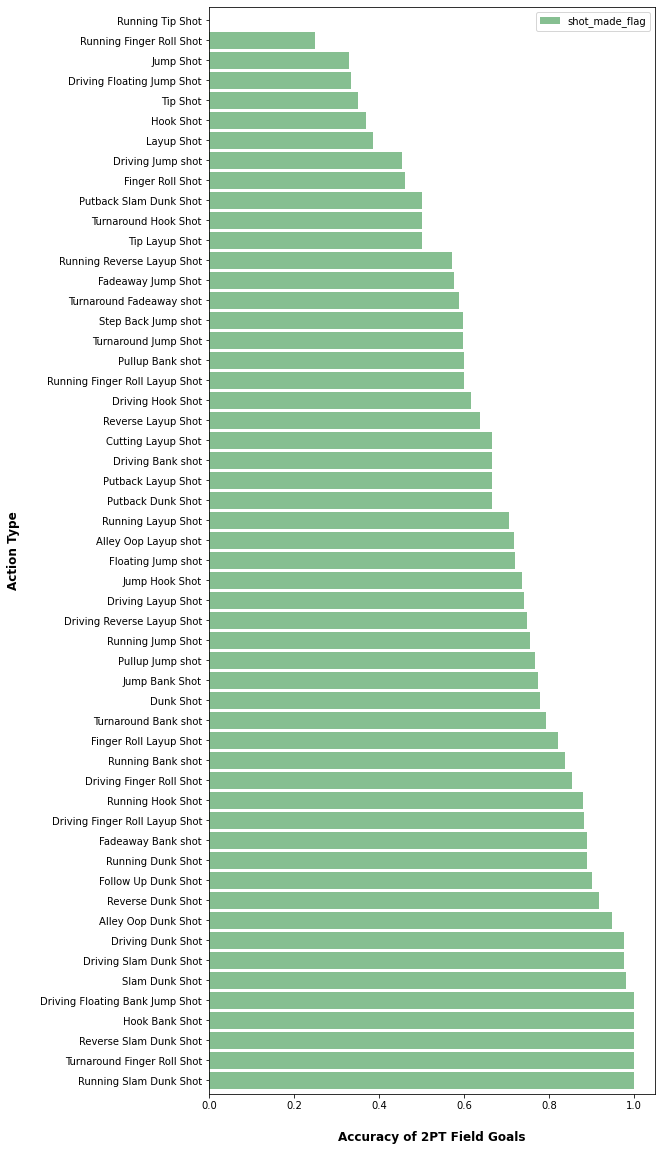

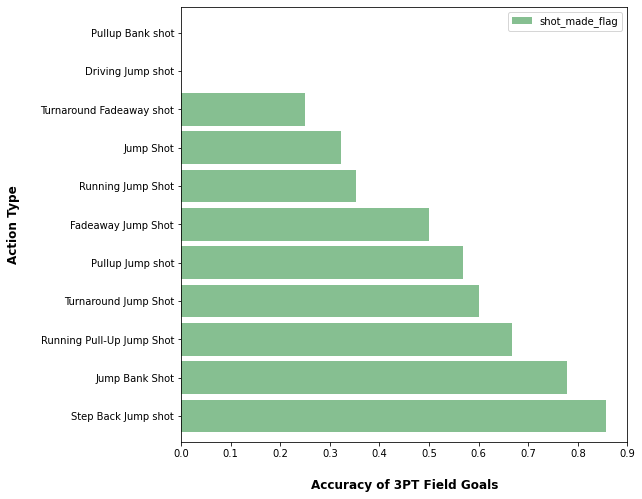

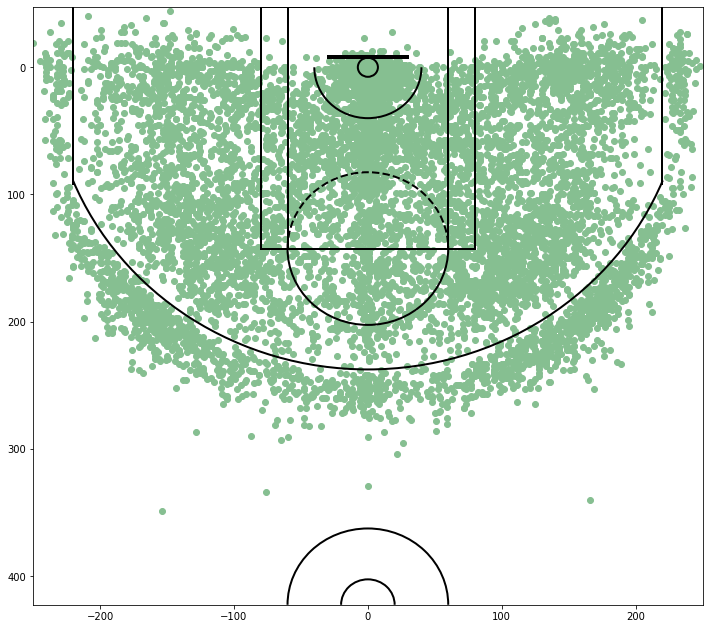

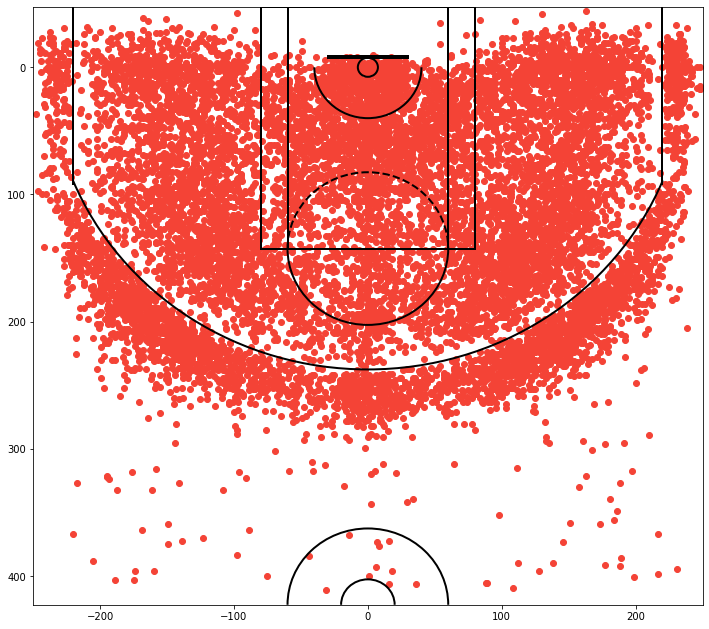

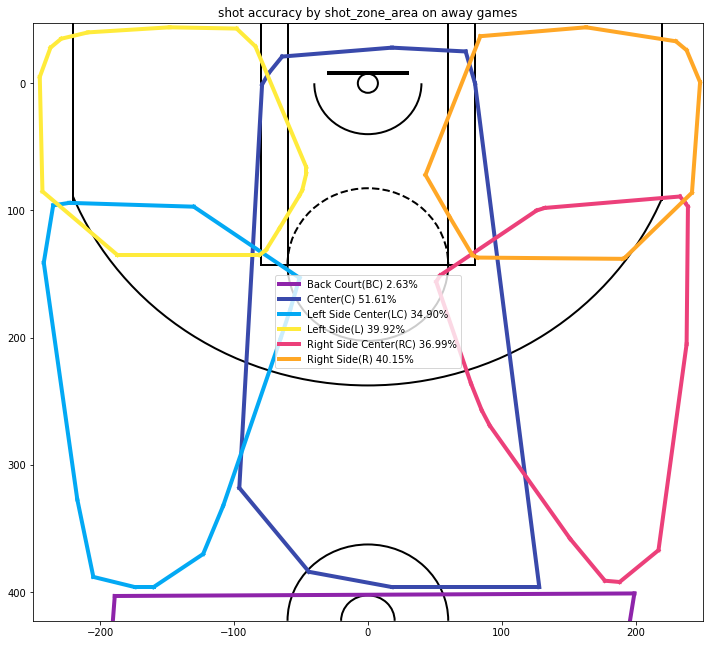

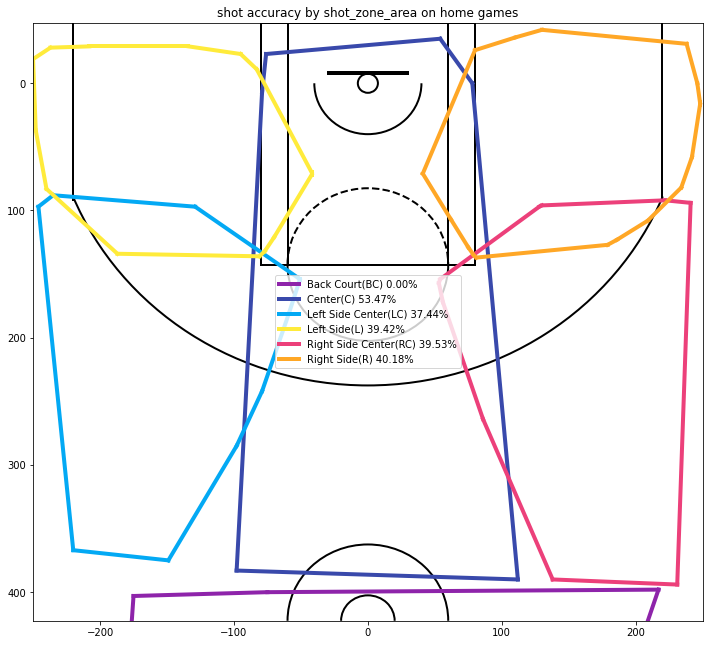

KeyError: "['game_year', 'game_day', 'game_month'] not in index"

In [13]:
utils.draw_exploratory_data_charts(data, test, chosen_features)

In [ ]:
utils.db_scan(data)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

X = data[chosen_features]
y = data['shot_made_flag']

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

n_splits = 5

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(criterion='entropy',
                              n_estimators=300, random_state=1, max_depth=8) #after several tests, this were the best params
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(base_estimator = clf1)
clf5 = AdaBoostClassifier(base_estimator = RandomForestClassifier(criterion='entropy', n_estimators=2, random_state=1))
clf6 = AdaBoostClassifier(base_estimator = clf3)
clf7 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf8 = ExtraTreesClassifier(n_estimators=50)
clf9 = GradientBoostingClassifier(n_estimators=400, max_depth=4)

eclf = VotingClassifier(
estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('lrada', clf4), ('rfada', clf5), ('gnada', clf6), ('ada', clf7), ('extra', clf8), ('gradient', clf9)],
voting='hard')

seclf = StackingClassifier(estimators=[('rf', clf2), ('ada', clf7), ('gradient', clf9)], final_estimator=RandomForestClassifier(criterion='entropy', n_estimators=2, random_state=1))

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, eclf, seclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Logistic Regression Ada', 'Random Forest Ada', 'naive bayes Ada', 'Adaboost', 'ExtraTrees','gradient', 'Ensemble', "StackingClassifier"]):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=TimeSeriesSplit(n_splits=n_splits))
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.65 (+/- 0.01) [Logistic Regression]
Accuracy: 0.71 (+/- 0.01) [Random Forest]
Accuracy: 0.64 (+/- 0.01) [naive Bayes]
Accuracy: 0.65 (+/- 0.00) [Logistic Regression Ada]
Accuracy: 0.66 (+/- 0.01) [Random Forest Ada]
Accuracy: 0.48 (+/- 0.04) [naive bayes Ada]
Accuracy: 0.70 (+/- 0.01) [Adaboost]
Accuracy: 0.69 (+/- 0.01) [ExtraTrees]
Accuracy: 0.71 (+/- 0.01) [gradient]
Accuracy: 0.71 (+/- 0.01) [Ensemble]
Accuracy: 0.64 (+/- 0.01) [StackingClassifier]


In [ ]:
tscv = TimeSeriesSplit()
params = {
    "loss":["deviance"],
    "learning_rate":[0.01, 0.025, 0.05, 0.075, 0.1, 0.2],
    "n_estimators":[10, 50, 100, 200, 300, 400, 500, 600],
    "subsample":[0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    "criterion":['friedman_mse', 'mae'],
    "max_depth":[3, 4, 5, 8],
    "max_features":["sqrt", "log2"],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12)
}
clf = GridSearchCV(GradientBoostingClassifier(), params, cv=tscv)
clf.fit(X, y)
print(clf.score(X, y))
print(clf.best_params_)

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
target = data['shot_made_flag']
trainData = data[chosen_features]

print("Five-fold cross validation on XGBoost: ")
X = trainData
y = target

clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:hinge')
score = cross_val_score(clf, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on XGBoost: 
0.6014708458927421


In [42]:
print("Five-fold Time Series Split on XGBoost: ")
clfxgb = xgb.XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:hinge')
score = cross_val_score(clf, X, y, cv=TimeSeriesSplit())
print(sum(score) / len(score))

Five-fold Time Series Split on XGBoost: 
0.643717888836992


In [39]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.04, 0.05, 0.06, 0.07], 
              'max_depth': [4, 5, 6, 7],
              'min_child_weight': [11, 10, 9, 12],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], 
              'seed': [1000]}

clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=TimeSeriesSplit())
clf.fit(X, y)
print(clf.score(X, y))
print(clf.best_params_)

0.7689224423084406
{'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 4, 'min_child_weight': 12, 'n_estimators': 1000, 'objective': 'binary:logistic', 'seed': 1000, 'subsample': 0.8}
